## 1. Import Libraries and Download Required Data

In [6]:
import nltk
import string
from collections import Counter
from nltk.corpus import movie_reviews, stopwords
from nltk.util import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

nltk.download('movie_reviews')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/shreyjain/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shreyjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shreyjain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shreyjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shreyjain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Dataset Preparation

In [7]:
fileids = movie_reviews.fileids()
len(fileids)

2000

In [8]:
selected_reviews = fileids[:500]
len(selected_reviews)

500

In [9]:
raw_text = ' '.join([movie_reviews.raw(fileid) for fileid in selected_reviews])
len(raw_text)

1813922

### Preprocessing: Lowercase, Remove Punctuation, Remove Stopwords, Tokenize

In [10]:
text_lower = raw_text.lower()

text_no_punct = text_lower.translate(str.maketrans('', '', string.punctuation))

tokens = text_no_punct.split()

stop_words = set(stopwords.words('english'))
tokens_clean = [word for word in tokens if word not in stop_words and word.strip()]

len(tokens_clean)

166586

## 3. N-gram Generation

### Unigrams

In [11]:
unigrams = list(ngrams(tokens_clean, 1))
unigrams[:10]

[('plot',),
 ('two',),
 ('teen',),
 ('couples',),
 ('go',),
 ('church',),
 ('party',),
 ('drink',),
 ('drive',),
 ('get',)]

In [12]:
unigram_freq = Counter(unigrams)
top_10_unigrams = unigram_freq.most_common(10)
top_10_unigrams

[(('film',), 1951),
 (('movie',), 1402),
 (('one',), 1267),
 (('like',), 942),
 (('even',), 703),
 (('good',), 561),
 (('time',), 552),
 (('get',), 540),
 (('much',), 523),
 (('films',), 487)]

### Bigrams

In [13]:
bigrams_list = list(ngrams(tokens_clean, 2))
bigrams_list[:10]

[('plot', 'two'),
 ('two', 'teen'),
 ('teen', 'couples'),
 ('couples', 'go'),
 ('go', 'church'),
 ('church', 'party'),
 ('party', 'drink'),
 ('drink', 'drive'),
 ('drive', 'get'),
 ('get', 'accident')]

In [14]:
bigram_freq = Counter(bigrams_list)
top_10_bigrams = bigram_freq.most_common(10)
top_10_bigrams

[(('special', 'effects'), 99),
 (('even', 'though'), 53),
 (('new', 'york'), 45),
 (('high', 'school'), 41),
 (('look', 'like'), 37),
 (('dont', 'know'), 37),
 (('looks', 'like'), 36),
 (('bad', 'movie'), 35),
 (('van', 'damme'), 35),
 (('action', 'sequences'), 31)]

### Trigrams

In [15]:
trigrams_list = list(ngrams(tokens_clean, 3))
trigrams_list[:10]

[('plot', 'two', 'teen'),
 ('two', 'teen', 'couples'),
 ('teen', 'couples', 'go'),
 ('couples', 'go', 'church'),
 ('go', 'church', 'party'),
 ('church', 'party', 'drink'),
 ('party', 'drink', 'drive'),
 ('drink', 'drive', 'get'),
 ('drive', 'get', 'accident'),
 ('get', 'accident', 'one')]

In [16]:
trigram_freq = Counter(trigrams_list)
top_10_trigrams = trigram_freq.most_common(10)
top_10_trigrams

[(('wild', 'wild', 'west'), 18),
 (('know', 'last', 'summer'), 17),
 (('0', '4', '4'), 14),
 (('new', 'york', 'city'), 14),
 (('tommy', 'lee', 'jones'), 12),
 (('jan', 'de', 'bont'), 12),
 (('saturday', 'night', 'live'), 11),
 (('freddie', 'prinze', 'jr'), 10),
 (('dont', 'get', 'wrong'), 10),
 (('4', '0', '10'), 9)]

## 4. Probability Computation

### Sample Sentence for Probability Calculation

In [17]:
sample_sentence = "the movie was really good"
sample_tokens = sample_sentence.split()
sample_tokens

['the', 'movie', 'was', 'really', 'good']

### Bigram Probability using MLE (without smoothing)

In [18]:
def bigram_probability_mle(sentence_tokens, bigram_counts, unigram_counts):
    probability = 1.0
    probabilities = []
    
    for i in range(len(sentence_tokens) - 1):
        w1 = (sentence_tokens[i],)
        w2 = (sentence_tokens[i], sentence_tokens[i+1])
        
        count_bigram = bigram_counts.get(w2, 0)
        count_unigram = unigram_counts.get(w1, 0)
        
        if count_unigram > 0:
            prob = count_bigram / count_unigram
        else:
            prob = 0
        
        probabilities.append((w2, prob))
        probability *= prob
    
    return probability, probabilities

sentence_prob_mle, word_probs_mle = bigram_probability_mle(sample_tokens, bigram_freq, unigram_freq)
word_probs_mle

[(('the', 'movie'), 0),
 (('movie', 'was'), 0.0),
 (('was', 'really'), 0),
 (('really', 'good'), 0.012165450121654502)]

In [19]:
sentence_prob_mle

0.0

### Bigram Probability with Laplace Smoothing

In [20]:
def bigram_probability_laplace(sentence_tokens, bigram_counts, unigram_counts, vocab_size):
    probability = 1.0
    probabilities = []
    
    for i in range(len(sentence_tokens) - 1):
        w1 = (sentence_tokens[i],)
        w2 = (sentence_tokens[i], sentence_tokens[i+1])
        
        count_bigram = bigram_counts.get(w2, 0)
        count_unigram = unigram_counts.get(w1, 0)
        
        prob = (count_bigram + 1) / (count_unigram + vocab_size)
        
        probabilities.append((w2, prob))
        probability *= prob
    
    return probability, probabilities

vocab_size = len(unigram_freq)
sentence_prob_laplace, word_probs_laplace = bigram_probability_laplace(sample_tokens, bigram_freq, unigram_freq, vocab_size)
word_probs_laplace

[(('the', 'movie'), 4.344803614876608e-05),
 (('movie', 'was'), 4.095339503644852e-05),
 (('was', 'really'), 4.344803614876608e-05),
 (('really', 'good'), 0.00025611473940325265)]

In [21]:
sentence_prob_laplace

1.9799981554289677e-17

### Comparison of Probabilities

In [22]:
comparison_df = pd.DataFrame({
    'Method': ['MLE (No Smoothing)', 'Laplace Smoothing'],
    'Sentence Probability': [sentence_prob_mle, sentence_prob_laplace]
})
comparison_df

,Method,Sentence Probability
0,MLE (No Smoothing),0.000000e+00
1,Laplace Smoothing,1.979998e-17


## 5. Visualization

### Top 10 Unigrams Bar Chart

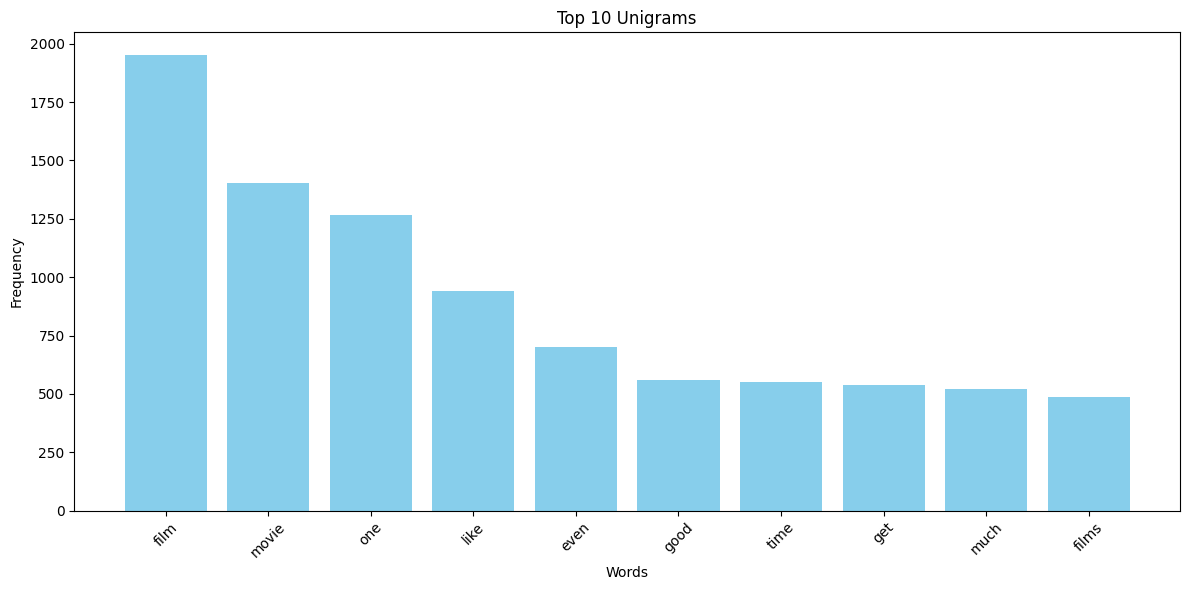

In [23]:
words = [word[0][0] for word in top_10_unigrams]
counts = [count for word, count in top_10_unigrams]

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Unigrams')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 10 Bigrams Bar Chart

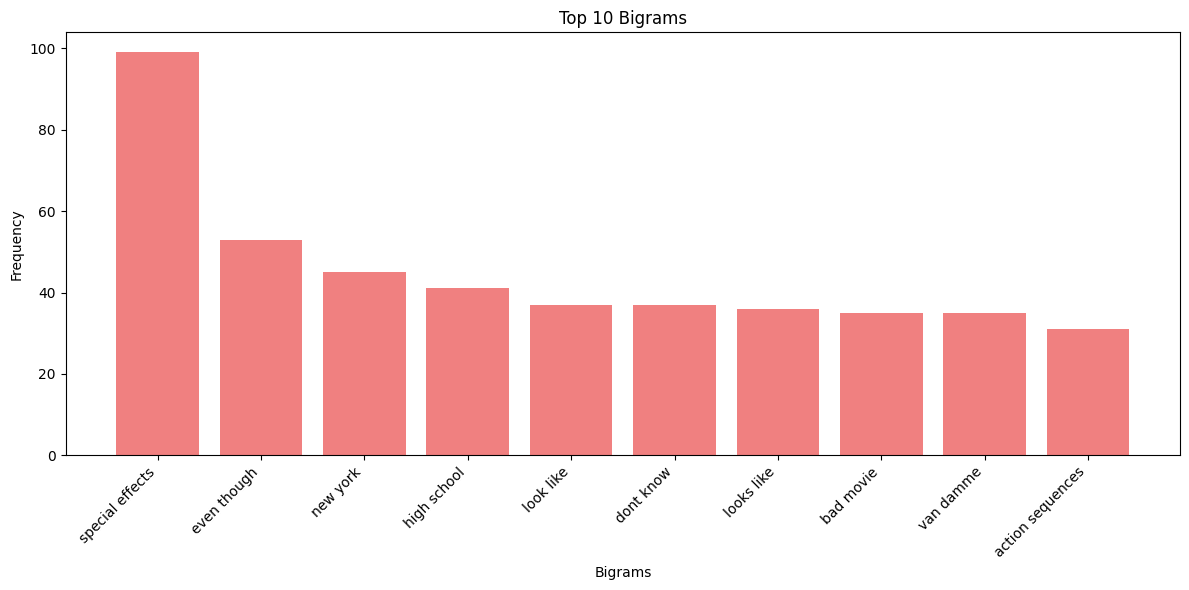

In [25]:
bigram_labels = [' '.join(bigram) for bigram, count in top_10_bigrams]
bigram_counts = [count for bigram, count in top_10_bigrams]

plt.figure(figsize=(12, 6))
plt.bar(bigram_labels, bigram_counts, color='lightcoral')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Top 10 Bigrams')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Top 10 Trigrams Bar Chart

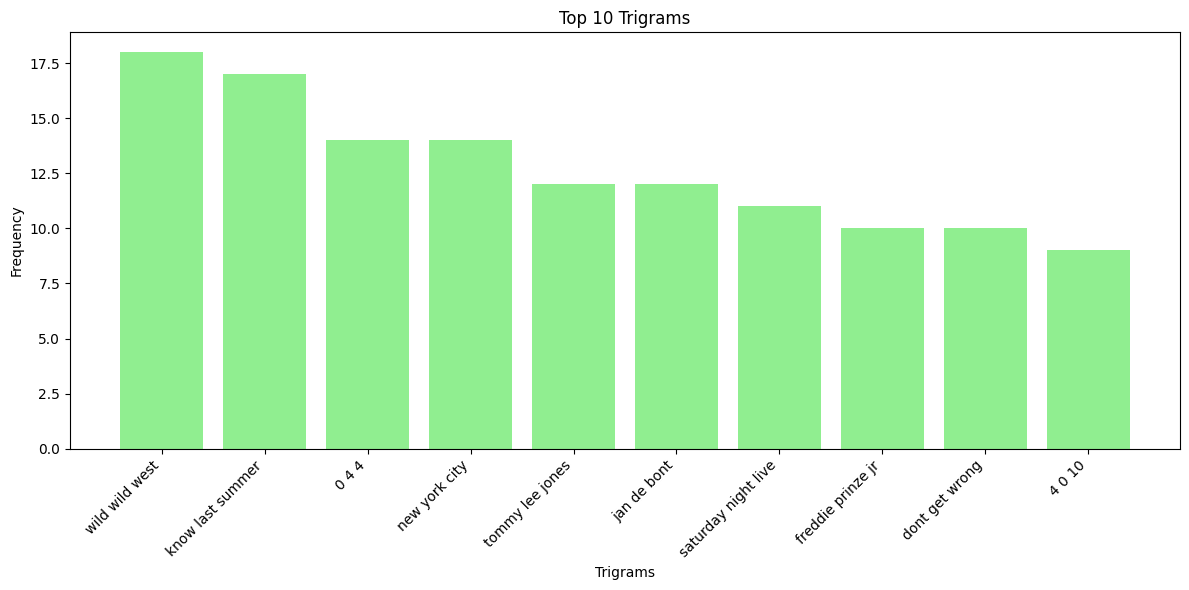

In [26]:
trigram_labels = [' '.join(trigram) for trigram, count in top_10_trigrams]
trigram_counts = [count for trigram, count in top_10_trigrams]

plt.figure(figsize=(12, 6))
plt.bar(trigram_labels, trigram_counts, color='lightgreen')
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Top 10 Trigrams')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Word Cloud for Unigrams

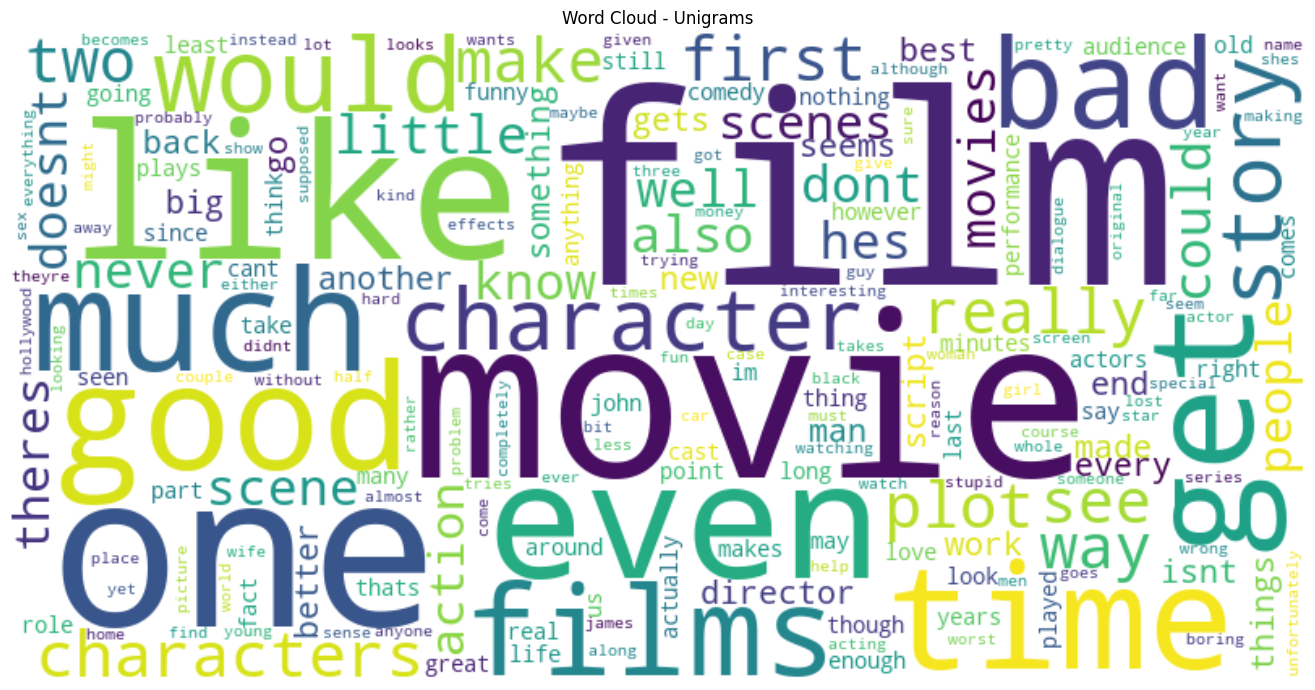

In [27]:
unigram_dict = {word[0]: count for word, count in unigram_freq.items()}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Unigrams')
plt.tight_layout()
plt.show()

### Word Cloud for Bigrams

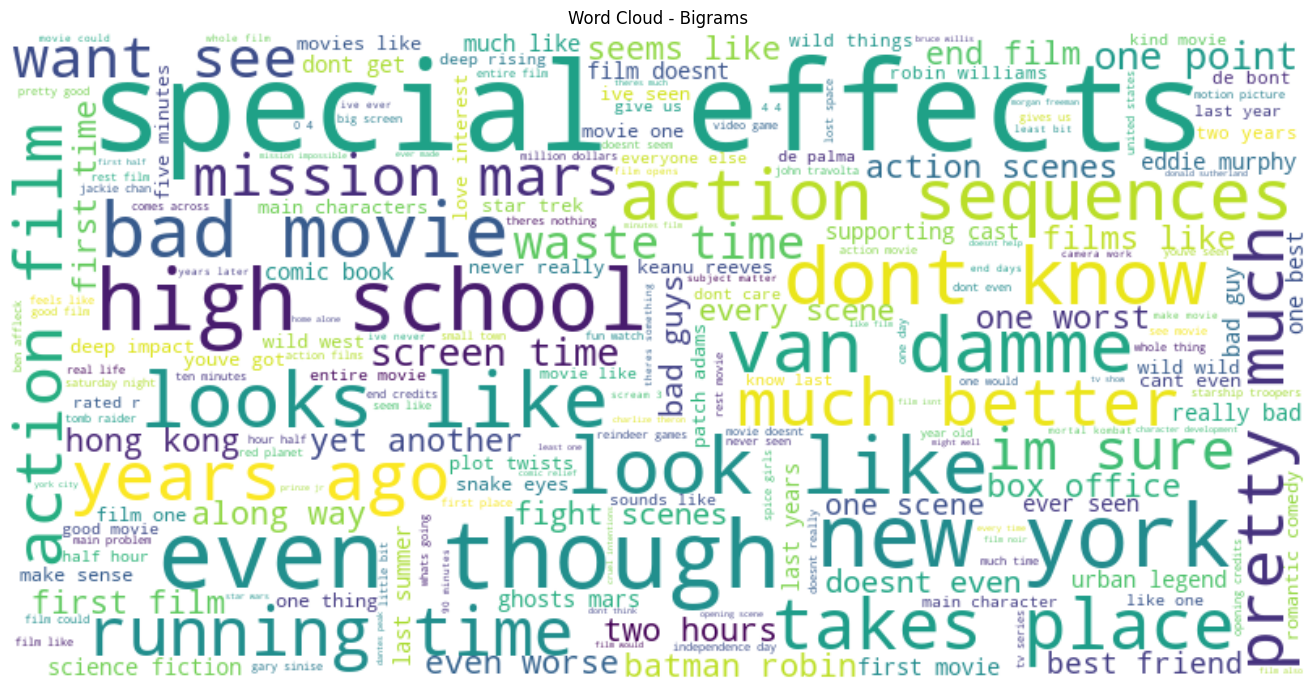

In [28]:
bigram_dict = {' '.join(bigram): count for bigram, count in bigram_freq.items()}

wordcloud_bigram = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_bigram, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Bigrams')
plt.tight_layout()
plt.show()

### Word Cloud for Trigrams

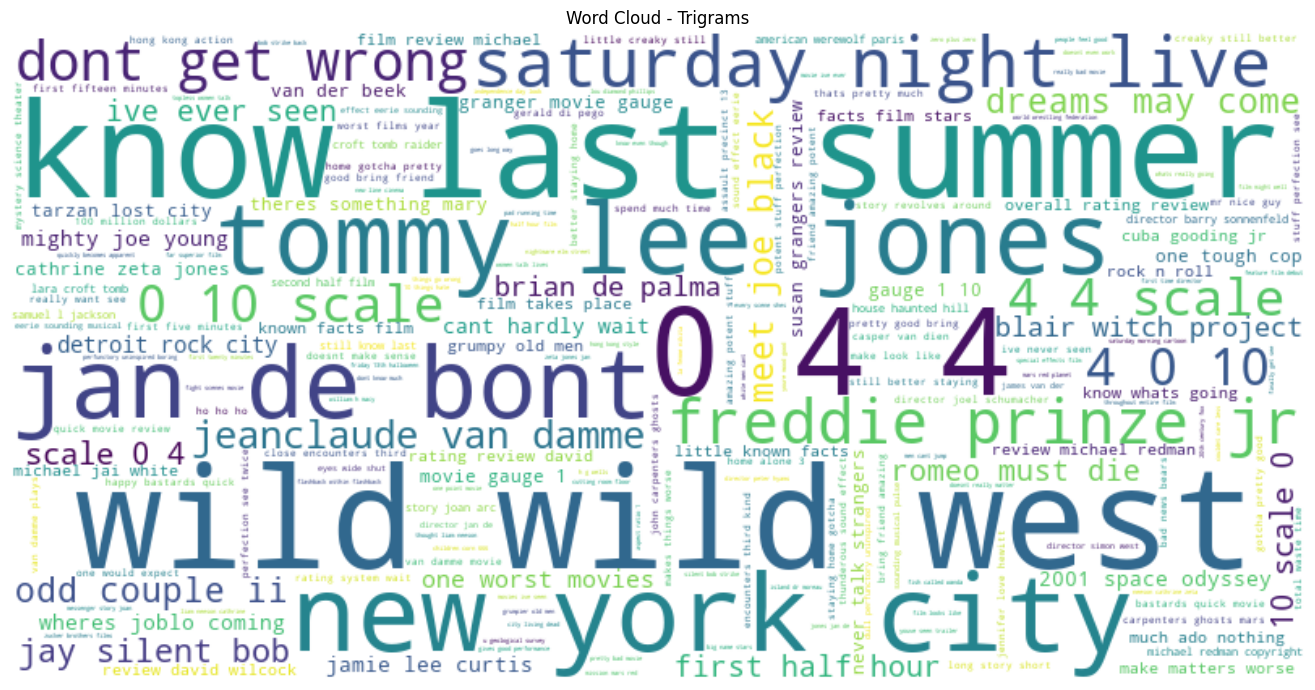

In [29]:
trigram_dict = {' '.join(trigram): count for trigram, count in trigram_freq.items()}

wordcloud_trigram = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_trigram, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Trigrams')
plt.tight_layout()
plt.show()